In [1]:
import numpy as np
from scipy.sparse import csr_matrix
import scipy.sparse.linalg
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
def updateWLRAgrad(X, W, v, u, step=None, gamma=3, beta=4, reg_lambda=0.1):
    """
    Updates a single factor matrix (u) while keeping the other (v) fixed.
    Includes L2 regularization.
    """
    R = u.dot(v.T) - X  # Residual matrix
    WR = W.multiply(R)  # Masked residual
    gradu = WR.dot(v) + reg_lambda * u  # Gradient with L2 regularization

    if step is None or not step:  # Check if step is empty or None
        step = 2 * np.linalg.norm(u) / np.linalg.norm(gradu)

    e0 = np.sum(WR.power(2)) + reg_lambda * np.sum(u ** 2)
    e1 = float('inf')
    while e1 > e0:
        unew = u - step * gradu
        step /= gamma
        e1 = np.sum((W.multiply(X - unew.dot(v.T))).power(2)) + reg_lambda * np.sum(unew ** 2)
    u = unew
    step *= beta
    return u, step, e1

In [3]:
# Load data matrix
data = loadmat('Data/matlab/inputX.mat')  # Load the .mat file
X = data['X']  # Assuming the matrix is stored under the key 'X'
X = csr_matrix(X)  # Convert to sparse matrix
m, n = X.shape
numX = X.count_nonzero()

# Construct binary weight matrix
W = X.copy()
W.data = np.ones_like(W.data)

rank = 5

# Init.2: average per row
v = np.ones((n, rank))
u = np.random.rand(m, rank)
for i in range(m):
    non_zero_indices = X[i].nonzero()[1]
    if len(non_zero_indices) > 0:
        u[i] = np.array([X[i, non_zero_indices].mean() for _ in range(len(u[i]))])

Iteration 1, RMSE: 6.897511228684351
Iteration 2, RMSE: 5.2060341671395225
Iteration 3, RMSE: 4.275924061429775
Iteration 4, RMSE: 3.7759892003081776
Iteration 5, RMSE: 3.3371442130828233
Iteration 6, RMSE: 2.9614344756782818
Iteration 7, RMSE: 2.6780705461616408
Iteration 8, RMSE: 2.520002383429509
Iteration 9, RMSE: 2.406578627306476
Iteration 10, RMSE: 2.3564905108769976
Iteration 11, RMSE: 2.213720614162691
Iteration 12, RMSE: 2.1480384141095548
Iteration 13, RMSE: 2.0911410815379767
Iteration 14, RMSE: 2.029859571277795
Iteration 15, RMSE: 1.9778479391800152
Iteration 16, RMSE: 1.9255569394262713
Iteration 17, RMSE: 1.8664621648882653
Iteration 18, RMSE: 1.822067339599991
Iteration 19, RMSE: 1.774545447499417
Iteration 20, RMSE: 1.7500698625244844
Iteration 21, RMSE: 1.7106638501198275
Iteration 22, RMSE: 1.6808938155784872
Iteration 23, RMSE: 1.6556940415223247
Iteration 24, RMSE: 1.6387150348007533
Iteration 25, RMSE: 1.6058114165803603
Iteration 26, RMSE: 1.5789726073610149
Ite

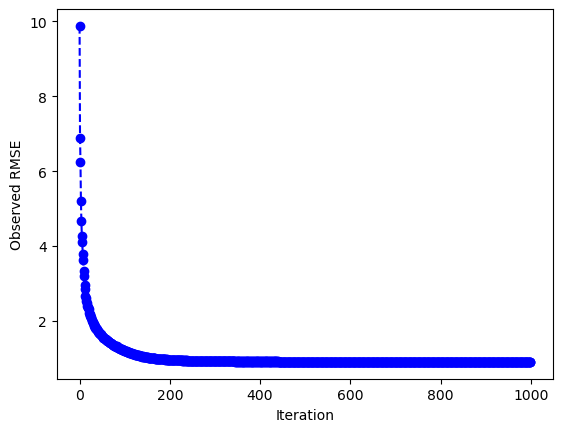

In [4]:
# Estimate the parameters of the model: Optimize u and v alternatively via gradient descent
k = 1
max_k = 500
uprec = u
stepu = []
stepv = []
e = []
while k <= max_k and (k <= 2 or (e[-2] - e[-1]) / e[-2] > 1e-6):  # Stopping criterion
    # Update u
    u, stepu, eu = updateWLRAgrad(X, W, v, u, stepu)
    # Update v
    v, stepv, ev = updateWLRAgrad(X.T, W.T, u, v, stepv)
    e.extend([np.sqrt(eu / numX), np.sqrt(ev / numX)])
    print(f"Iteration {k}, RMSE: {e[-1]}")
    k += 1

# Display the evolution of the RMSE
plt.figure()
plt.xlabel('Iteration')
plt.ylabel('Observed RMSE')
plt.plot(e, 'bo--')
plt.show()

In [5]:
# Construct the prediction in a csv file
data_eval = loadmat('Data/matlab/inputEval.mat')
Eval = data_eval['Eval']
numpred = Eval.shape[0]
predic = np.zeros((numpred,2))
# predic[:,0] = np.linspace(1, numpred, numpred, endpoint=True).round().astype(int)
for i in range(numpred):
    predic[i,0] = int(i + 1)
    predic[i,1] = np.dot(u[Eval[i,0]-1], v[Eval[i,1]-1])
    # Make sure the prediction is in [1,5]
    predic[i,1] = max(1, predic[i,1])
    predic[i,1] = min(5, predic[i,1])
np.savetxt('l2_reg.csv', predic, delimiter=',', fmt=["%d"] + ["%.4f"], header="ID,Rating",comments='')